In [2]:
import pygame
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

pygame 2.6.1 (SDL 2.28.4, Python 3.12.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
class PongEnv:
    def __init__(self):
        self.width = 400
        self.height = 400
        self.paddle_width = 10
        self.paddle_height = 60
        self.ball_size = 10
        self.paddle_speed = 5
        self.ball_speed = 5
        
        # Initialize positions
        self.paddle_pos = self.height // 2
        self.ball_pos = [self.width // 2, self.height // 2]
        self.ball_direction = [1, 1]  # [x_dir, y_dir]
        
        # Initialize Pygame flag
        self.pygame_initialized = False
        
    def init_pygame(self):
        if not self.pygame_initialized:
            pygame.init()
            self.screen = pygame.display.set_mode((self.width, self.height))
            self.clock = pygame.time.Clock()
            self.pygame_initialized = True
        
    def reset(self):
        # Initialize/reinitialize Pygame if needed
        self.init_pygame()
                
        self.paddle_pos = self.height // 2
        self.ball_pos = [self.width // 2, self.height // 2]
        self.ball_direction = [1, random.uniform(-1, 1)]
        
        # Handle any pending events
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                self.close()
                raise SystemExit()
                
        return self._get_state()
    
    def _get_state(self):
        return np.array([
            self.paddle_pos / self.height,
            self.ball_pos[1] / self.height,
            self.ball_pos[0] / self.width,
            self.ball_direction[0],
            self.ball_direction[1]
        ])
    
    def step(self, action):
        # Initialize Pygame if needed
        self.init_pygame()
        
        # Handle events
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                self.close()
                raise SystemExit()
        
        # Update paddle position (0: stay, 1: up, 2: down)
        if action == 1:
            self.paddle_pos = max(self.paddle_height // 2,
                                self.paddle_pos - self.paddle_speed)
        elif action == 2:
            self.paddle_pos = min(self.height - self.paddle_height // 2,
                                self.paddle_pos + self.paddle_speed)
        
        # Update ball position
        self.ball_pos[0] += self.ball_speed * self.ball_direction[0]
        self.ball_pos[1] += self.ball_speed * self.ball_direction[1]
        
        # Ball collision with top and bottom
        if self.ball_pos[1] <= 0 or self.ball_pos[1] >= self.height:
            self.ball_direction[1] *= -1
        
        # Ball collision with paddle
        if (self.ball_pos[0] <= self.paddle_width and
            abs(self.ball_pos[1] - self.paddle_pos) < self.paddle_height // 2):
            self.ball_direction[0] *= -1
            reward = 1
            done = False
        # Ball passes paddle
        elif self.ball_pos[0] <= 0:
            reward = -1
            done = True
        # Ball hits right wall
        elif self.ball_pos[0] >= self.width:
            self.ball_direction[0] *= -1
            reward = 0
            done = False
        else:
            reward = 0
            done = False
        
        return self._get_state(), reward, done

    def render(self):
        # Initialize Pygame if needed
        self.init_pygame()
        
        # Handle events
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                self.close()
                raise SystemExit()
        
        self.screen.fill((0, 0, 0))
        
        # Draw paddle
        pygame.draw.rect(self.screen, (255, 255, 255),
                        (0, self.paddle_pos - self.paddle_height // 2,
                         self.paddle_width, self.paddle_height))
        
        # Draw ball
        pygame.draw.rect(self.screen, (255, 255, 255),
                        (int(self.ball_pos[0] - self.ball_size // 2),
                         int(self.ball_pos[1] - self.ball_size // 2),
                         self.ball_size, self.ball_size))
        
        pygame.display.flip()
        self.clock.tick(30)

    def close(self):
        if self.pygame_initialized:
            pygame.quit()
            self.pygame_initialized = False

In [4]:
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )
    
    def forward(self, x):
        return self.network(x)

In [5]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return (np.stack(state), np.array(action), np.array(reward),
                np.stack(next_state), np.array(done))
    
    def __len__(self):
        return len(self.buffer)

In [6]:
def train(env, episodes=1000, batch_size=64, gamma=0.99,
          epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
          render_frequency=10):
    try:
        input_size = 5  # State size
        output_size = 3  # Number of actions
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        policy_net = DQN(input_size, output_size).to(device)
        target_net = DQN(input_size, output_size).to(device)
        target_net.load_state_dict(policy_net.state_dict())
        
        optimizer = optim.Adam(policy_net.parameters())
        memory = ReplayBuffer(10000)
        
        epsilon = epsilon_start
        scores = []
        
        for episode in range(episodes):
            state = env.reset()
            score = 0
            done = False
            
            # Determine if this episode should be rendered
            should_render = episode % render_frequency == 0
            
            while not done:
                # Select action
                if random.random() > epsilon:
                    with torch.no_grad():
                        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                        action = policy_net(state_tensor).max(1)[1].item()
                else:
                    action = random.randrange(output_size)
                
                # Take action
                next_state, reward, done = env.step(action)
                score += reward
                
                # Store transition
                memory.push(state, action, reward, next_state, done)
                state = next_state
                
                # Render game only for specified episodes
                if should_render:
                    env.render()
                    time.sleep(0.03)  # Add slight delay for better visualization
                
                # Train if enough samples
                if len(memory) >= batch_size:
                    states, actions, rewards, next_states, dones = memory.sample(batch_size)
                    
                    states = torch.FloatTensor(states).to(device)
                    actions = torch.LongTensor(actions).to(device)
                    rewards = torch.FloatTensor(rewards).to(device)
                    next_states = torch.FloatTensor(next_states).to(device)
                    dones = torch.FloatTensor(dones).to(device)
                    
                    # Compute Q values
                    current_q = policy_net(states).gather(1, actions.unsqueeze(1))
                    next_q = target_net(next_states).max(1)[0].detach()
                    target_q = rewards + gamma * next_q * (1 - dones)
                    
                    # Compute loss and update
                    loss = nn.MSELoss()(current_q.squeeze(), target_q)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            
            # Update target network
            if episode % 10 == 0:
                target_net.load_state_dict(policy_net.state_dict())
            
            # Decay epsilon
            epsilon = max(epsilon_end, epsilon * epsilon_decay)
            
            # Record score
            scores.append(score)
            
            # Display progress
            if episode % 10 == 0:
                clear_output(True)
                plt.figure(figsize=(8, 6))
                plt.plot(scores)
                plt.title('Training Progress')
                plt.xlabel('Episode')
                plt.ylabel('Score')
                plt.show()
                
                print(f"Episode: {episode}, Score: {score}, Epsilon: {epsilon:.2f}")
    
    except (KeyboardInterrupt, SystemExit):
        print("\nTraining interrupted")
    finally:
        env.close()
        
    return policy_net, scores

In [7]:
def test_model(model, env, episodes=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    try:
        for episode in range(episodes):
            state = env.reset()
            done = False
            score = 0
            
            while not done:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                    action = model(state_tensor).max(1)[1].item()
                
                state, reward, done = env.step(action)
                score += reward
                env.render()
                time.sleep(0.03)  # Slow down visualization
            
            print(f"Test Episode {episode + 1}: Score = {score}")
    
    except (KeyboardInterrupt, SystemExit):
        print("\nTesting interrupted")
    finally:
        env.close()

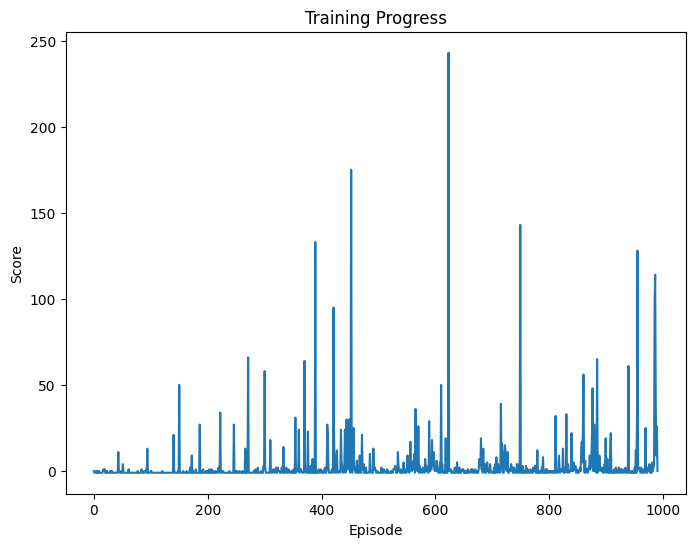

Episode: 990, Score: 0, Epsilon: 0.01


In [8]:
env = PongEnv()
trained_model, training_scores = train(env, render_frequency=10)
torch.save(trained_model.state_dict(), 'pong_model.pth')



In [10]:
test_env = PongEnv()
test_model(trained_model, test_env)

Test Episode 1: Score = 3
Test Episode 2: Score = 13

Testing interrupted
